In [7]:
# import ipopt
import scipy
import numpy as np
import numpy.linalg as LA
from numpy.polynomial import Chebyshev as T
import gen_mat as gen
import matplotlib.pyplot as plt
from numba import jit, prange
from mva_test import *
%matplotlib inline
import os

prange = xrange

In [67]:
class hs071(object):
    def __init__(self):
        pass

    @jit(parallel=True, nogil=True)
    def objective(self, points):
        tol = 1e-12
        if (points.ndim == 1 or points.shape[1] == 1):
            points = points.reshape(-1, dim, order='F')
        points = np.stack(np.split(points.T.ravel(), dim), 1)
        A = gen.GenMat(num_col, points, poly=gen.cheb, ToGenDiff=False)
        S = LA.svd(A, compute_uv=False)
        S[S < tol] = tol
        ld = 2.0*np.sum(np.log(S))
        return -ld

    @jit(parallel=True, nogil=True)
    def gradient(self, points):
        tol = 1e-12
        if (points.ndim == 1 or points.shape[1] == 1):
            points = points.reshape(-1, dim, order='F')

        idx = np.array(gen.indeces_K_cut(dim, num_col))
        max_degree = np.max(idx)

        num_of_points = points.shape[0]
        tot_elems = points.size

        T_deriv = np.empty((tot_elems, max_degree + 1), dtype=points.dtype)
        T_val = np.empty((tot_elems, max_degree + 1), dtype=points.dtype)
        points_flat = points.ravel('F')
        for i in prange(max_degree + 1):
            T_deriv[:, i] = T.deriv(T.basis(i))(points_flat)
            T_val[:, i] = T.basis(i)(points_flat)

        A = gen.GenMat(num_col, points, poly_vals=T_val,
                       indeces=idx,  ToGenDiff=False)

        _, S, V = LA.svd(A, full_matrices=False)
        S[S < tol] = tol
        B_inv = V.T.dot(np.diag(1./(S**2))).dot(V)

        grad_vec = np.zeros(tot_elems, dtype=points.dtype)
        for k in prange(tot_elems):
            col = k//num_of_points
            row = k % num_of_points
            A_row = A[row]
            idx_col = idx.T[col]
            for i in xrange(B_inv.shape[0]):
                alpha = T_deriv[k, idx_col[i]]/T_val[k, idx_col[i]]
                for j in xrange(B_inv.shape[0]):
                    grad_vec[k] += B_inv[j, i] * (A_row[i]*A_row[j]*(
                        alpha + T_deriv[k, idx_col[j]]/T_val[k, idx_col[j]]))
        return -grad_vec

    def constraints(self, x):
        #
        # The callback for calculating the constraints
        #
        return x[x.size//2:]**2+x[0:x.size//2]**2

    def jacobian(self, x):
        #
        # The callback for calculating the Jacobian
        #
        ret = np.zeros(2*num_pnts**2)
        ret[::2*num_pnts + 1] = 2*x[:num_pnts]
        ret[num_pnts::2*num_pnts + 1] = 2*x[num_pnts:]

        return ret


class hs_rad(hs071):
    def constraints(self, x):
        xi, yi = x[:x.size//2], x[x.size//2:]
        return np.concatenate((xi**2 + yi**2, np.arctan2(yi, xi)))

    def jacobian(self, x):
        slot_ln = 2*num_pnts**2
        ret = np.zeros(2*slot_ln)  # two times more constrains

        xi, yi = x[:num_pnts], x[num_pnts:]
        r2 = xi**2 + yi**2
        # diff the first cons
        ret[:slot_ln:2*num_pnts + 1] = 2*xi
        ret[num_pnts:slot_ln:2*num_pnts + 1] = 2*yi

        # diff the second cons
        ret[slot_ln::2*num_pnts + 1] = -yi/r2
        ret[num_pnts+slot_ln::2*num_pnts + 1] = xi/r2

        return ret

In [101]:
def get_points_from_zone(obj, cl, cu, N, dim=2, mode='LHS', coeff = 5.0, args={}):
    """
    obj is a class that have method 'constraints()'
    """
    nmb = int(coeff*N) # number of points with a margin
    # pnts = test_points_gen(nmb, dim, distib=mode).ravel('F') # x goes first, then y
    pnts = test_points_gen(nmb, dim, distib=mode, **args)
    pnts = np.array([i for i in pnts if np.all(cl <= obj.constraints(i)) and np.all(obj.constraints(i) <= cu) ])
    
    if len(pnts) < N: #Bad :(
        return get_points_from_zone(cl, cnst, dim=dim, mode=mode, coeff=2*coeff, args=args)
    else:
        return pnts[:N]


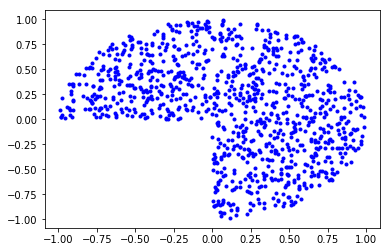

In [110]:
N = 1000
cl = [0.0, -0.5*np.pi]
cu = [1.0, np.pi]
pnt = get_points_from_zone(hs_rad(), cl, cu, N, mode='LHS')
# print (pnt)
plt.plot(pnt[:, 0], pnt[:, 1], 'b.');

In [30]:
dim = 2
num_pnts = 3
x = np.array([1, 2, 3, 4, 5, 6], dtype=float)

hs = hs071()
print(hs.constraints(x))
print(hs.jacobian(x))

hs = hs_rad()
print(hs.constraints(x))
print(hs.jacobian(x))

[17. 29. 45.]
[ 2.  0.  0.  8.  0.  0.  0.  4.  0.  0. 10.  0.  0.  0.  6.  0.  0. 12.]
[17.           29.           45.            1.3258176637  1.1902899497  1.1071487178]
[ 2.            0.            0.            8.            0.            0.            0.            4.
  0.            0.           10.            0.            0.            0.            6.            0.
  0.           12.           -0.2352941176  0.            0.            0.0588235294  0.            0.
  0.           -0.1724137931  0.            0.            0.0689655172  0.            0.            0.
 -0.1333333333  0.            0.            0.0666666667]


In [81]:
# -----------CONDITIONS-----------------------
# See https://pythonhosted.org/ipopt/tutorial.html
np.random.seed(1)

global num_col
global dim
num_col = 20
num_pnts = 51
dim = 2

x0 = test_points_gen(num_pnts, dim, distrib='LHS').ravel('F')

lb = list(-0.4*np.ones(2*num_pnts))
ub = list( 0.4*np.ones(2*num_pnts))

cl = [0.17]*num_pnts + [-np.pi/2]*num_pnts
cu = [0.65]*num_pnts + [ np.pi  ]*num_pnts

nlp = ipopt.problem(
    n=len(x0),
    m=len(cl),
    problem_obj=hs071(),
    lb=lb,
    ub=ub,
    cl=cl,
    cu=cu
)

NameError: name 'ipopt' is not defined

In [34]:
nlp.addOption('mu_strategy', 'adaptive')
nlp.addOption('limited_memory_update_type', 'bfgs')
nlp.addOption('hessian_approximation', 'limited-memory')
#nlp.addOption('derivative_test','first-order')
#nlp.addOption('dual_inf_tol', np.float(1e4))
#nlp.addOption('max_iter', 195)
#nlp.addOption('compl_inf_tol', 1e-7)
nlp.addOption('constr_viol_tol', 1e-4)
#nlp.addOption('acceptable_iter', 2)
nlp.addOption('tol', 1e-6)
#nlp.addOption('jac_d_constant', 'yes')
#nlp.addOption('nlp_scaling_method', 'none')
#nlp.addOption('dual_inf_tol', 1)
#nlp.addOption('compl_inf_tol', 0.0002)

In [35]:
x, info = nlp.solve(x0)

GD error =  0.07954234618427795 



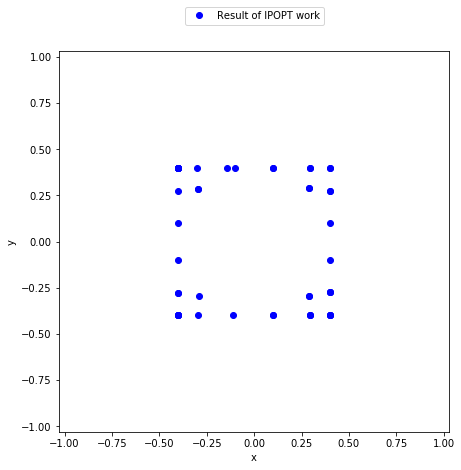

In [37]:
def rhs(points):
    return 2*np.exp(-((points[:,0]**2)/2. + (points[:,1]**2)/2.))

# approximation error (infinity norm) and comparison with MaxVol
M_gd = gen.GenMat(num_col, x.reshape(x.size//2,2,order='F'), poly = gen.cheb, ToGenDiff=False) 
c_gd = LA.solve(np.dot(M_gd.T, M_gd), np.dot(M_gd.T, rhs(x.reshape(x.size//2,2,order='F'))))

np.random.seed(100500)
test = -1 + (2)*np.random.rand(100000, dim)

M = gen.GenMat(num_col, test, poly = gen.cheb, ToGenDiff=False) 

print "GD error = ", LA.norm(rhs(test) - np.dot(M, c_gd), np.inf) / LA.norm(rhs(test), np.inf), "\n"

ax = plt.figure(figsize=(7,7))
plt.plot(x[:x.size//2],x[x.size//2:],'bo', label='Result of IPOPT work')
#plt.plot(x0[:x0.size//2],x0[x0.size//2:],'rx', label='x0')
#plt.plot(np.arange(-1,1.2,0.1),1.5*np.arange(-1,1.2,0.1)+0.85, 'k--', np.arange(-1,1.2,0.1),1.5*np.arange(-1,1.2,0.1)-0.85, 'k--')
#plt.plot(np.arange(-1,1.2,0.1),-1.5*np.arange(-1,1.2,0.1)+0.85, 'k--', np.arange(-1,1.2,0.1),-1.5*np.arange(-1,1.2,0.1)-0.85, 'k--')
plt.xlim(-1.03,1.03)
plt.ylim(-1.03,1.03)
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.13),ncol=3)
#plt.savefig('/Users/vitaly/Desktop/ipopt_circular.png', dpi = 400)
plt.show()

np.random.seed(42)
test_pnts = test_points_gen(int(1e5), dim)
#LebesgueConst(x.reshape(-1,dim,order='F'), num_col, poly=gen.cheb, test_pnts=test_pnts, pow_p=1)

In [66]:
[1]*5 + [2]*5

[1, 1, 1, 1, 1, 2, 2, 2, 2, 2]